In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [25]:
from pandas_datareader import data
start_date = '2001-01-01'
end_date = '2018-01-01'
SRC_DATA_FILENAME='goog_data_large.pkl'

In [26]:
try:
    goog_data = pd.read_pickle(SRC_DATA_FILENAME)
    print('File data found...reading GOOG data')
except FileNotFoundError:
    print('File not found...downloading the GOOG data')
    goog_data = data.DataReader('GOOG', 'yahoo', start_date, end_date)
    goog_data.to_pickle(SRC_DATA_FILENAME)

File data found...reading GOOG data


In [27]:
goog_data['Open-Close'] = goog_data.Open - goog_data.Close
goog_data['High-Low'] = goog_data.High - goog_data.Low
goog_data = goog_data.dropna()
X = goog_data[['Open-Close','High-Low']]
Y = np.where(goog_data['Close'].shift(-1) > goog_data['Close'],1,-1)

In [30]:
split_ratio = 0.8
split_value = int(split_ratio * len(goog_data))
X_train = X[:split_value]
Y_train = Y[:split_value]
X_test = X[split_value:]
Y_test = Y[split_value:]

In [31]:
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train, Y_train)
accuracy_train = accuracy_score(Y_train, knn.predict(X_train))
accuracy_test = accuracy_score(Y_test, knn.predict(X_test))

In [32]:
goog_data['Predicted_Signal'] = knn.predict(X)
goog_data['GOOG_Returns'] = np.log(goog_data['Close']/
                                 goog_data['Close'].shift(1))

In [33]:
def calculate_return(df, split_value, symbol):
    cum_goog_return= df[split_value:]['%s_Returns' % symbol].cumsum() * 100
    df['Strategy_Returns'] = df['%s_Returns' % symbol] * df['Predicted_Signal'].shift(1)
    return cum_goog_return

def calculate_strategy_return(df,split_value):
    cum_strategy_return = df[split_value:]['Strategy_Returns'].cumsum() * 100
    return cum_strategy_return

cum_goog_return=calculate_return(goog_data,split_value=len(X_train),symbol='GOOG')
cum_strategy_return= calculate_strategy_return(goog_data,split_value=len(X_train))


def plot_chart(cum_symbol_return, cum_strategy_return, symbol):
    plt.figure(figsize=(10,5))
    plt.plot(cum_symbol_return, label='%s Returns' % symbol)
    plt.plot(cum_strategy_return,label='Strategy Returns')
    plt.legend()
    plt.show()

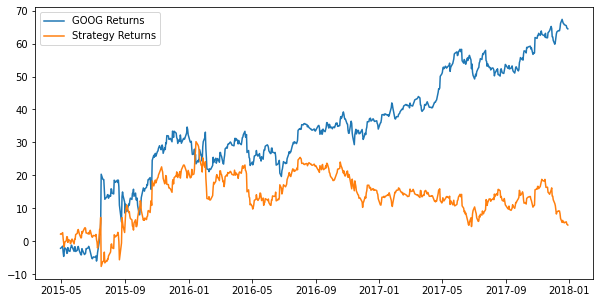

In [34]:
plot_chart(cum_goog_return, cum_strategy_return,symbol='GOOG')

In [35]:
def sharpe_ratio(symbol_returns, strategy_returns):
    strategy_std=strategy_returns.std()
    sharpe=(strategy_returns-symbol_returns)/strategy_std
    return sharpe.mean()

print(sharpe_ratio(cum_strategy_return,cum_goog_return))

1.1703640059473452
